# Chargement des libs

In [ ]:
import pandas as pd
import numpy as np
import json
import sqlite3
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import RandomForestClassifier
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import silhouette_score
from sklearn.decomposition import PCA
import tensorflow as tf

from utils.notebook_utils import setup_notebook_env
setup_notebook_env()

from utils.save_notebook_model import save_notebook_model

import warnings
warnings.filterwarnings('ignore')

# Collecte de données

In [314]:
db_path = "../data/xenty.db"
conn = sqlite3.connect(db_path)
query = "SELECT * FROM x_cryptos ORDER BY CASE WHEN market_cap_rank IS NULL THEN 999999 ELSE market_cap_rank END ASC"

df = pd.read_sql_query(query, conn)
conn.close()
print("📊 Dataset créé avec", len(df), "comptes crypto")
df.head()

📊 Dataset créé avec 7980 comptes crypto


,id,name,screen_name,description,is_blue_verified,followers_count,following_count,posts_count,posts,created_at,market_cap_rank,sync_at
0,357312062,Bitcoin,Bitcoin,Bitcoin is an open source censorship-resistant...,1,7788378,13,28585,"{""tweet-1941894468061569375"": {""created_at"": ""...",1313643968,1.0,1.751828e+09
1,2312333412,Ethereum,ethereum,"The universal platform for crypto, blockchain ...",1,3847295,0,4299,"{""tweet-1937947714920300627"": {""created_at"": ""...",1390763724,2.0,NaN
2,2893133450,Tether,Tether_to,Finance | Power | Data | Edu | Evo - Empowerin...,1,537857,246,1755,"{""tweet-1938132804270739805"": {""created_at"": ""...",1415394150,3.0,NaN
3,1051053836,Ripple,Ripple,We're building the Internet of Value.,1,3146294,986,9103,"{""tweet-1938276067502133466"": {""created_at"": ""...",1356983139,4.0,NaN
4,1052454006537314306,BNB Chain,BNBCHAIN,$100M Incentive Program is introducing a new d...,1,3848162,627,26821,"{""tweet-1938269416271061330"": {""created_at"": ""...",1539759563,5.0,NaN


# Nettoyage et préparation des données

In [315]:
# Fonction pour modifier le type de l'attribut views_count string -> int
def cast_views_count_to_int(post_json_str):
    if pd.isna(post_json_str):
        return post_json_str
    
    # Charger le JSON
    try:
        posts_dict = json.loads(post_json_str)
    except json.JSONDecodeError:
        # Si le JSON est invalide, retourner la valeur originale
        return post_json_str
    
    # Parcourir chaque tweet dans le dictionnaire
    for _, tweet_data in posts_dict.items():
        if 'views_count' in tweet_data:
            tweet_data['views_count'] = int(tweet_data.pop('views_count'))
    
    # Reconvertir en JSON string
    return json.dumps(posts_dict)

# Appliquer la fonction à la colonne posts
print("Début de la transformation...")
posts_before = json.loads(df.loc[0, 'posts'])
keys = posts_before.keys()
first_key = list(keys)[0] if keys else None
print(posts_before[first_key])
df['posts'] = df['posts'].apply(cast_views_count_to_int)
posts_after = json.loads(df.loc[0, 'posts'])
keys = posts_after.keys()
first_key = list(keys)[0] if keys else None
print(posts_after[first_key])
print("Transformation terminée!")

# Remplacer les valeurs manquantes par -1 et convertir en int
df['market_cap_rank'] = df['market_cap_rank'].fillna(-1).astype(int)
df['sync_at'] = df['sync_at'].fillna(0).astype(int)
df.tail()

Début de la transformation...
{'created_at': 'Sun Jul 06 16:18:14 +0000 2025', 'full_text': 'RT @zarathustra5150: People are about to discover that all sorts of quality-of-life metrics they never even considered will quietly start t…', 'views_count': 0, 'bookmark_count': 0, 'likes_count': 0, 'quote_count': 0, 'reply_count': 0, 'retweet_count': 1701, 'comments': []}
{'created_at': 'Sun Jul 06 16:18:14 +0000 2025', 'full_text': 'RT @zarathustra5150: People are about to discover that all sorts of quality-of-life metrics they never even considered will quietly start t…', 'bookmark_count': 0, 'likes_count': 0, 'quote_count': 0, 'reply_count': 0, 'retweet_count': 1701, 'comments': [], 'views_count': 0}
Transformation terminée!


,id,name,screen_name,description,is_blue_verified,followers_count,following_count,posts_count,posts,created_at,market_cap_rank,sync_at
7975,1932619199731675136,CoinElonSolana,CoinElonSolana,,0,21,0,1,None,1749607321,-1,0
7976,1933488137613025280,Commentary ShibEstee,TheEsteeCoin,$ESTEE: The original $SHIB. The fan Meme coin ...,0,1659,135,102,None,1749814490,-1,0
7977,1934669424239497216,roadmap coin,roadmapcoin,$RDMP is the coin of empty promises on @boopdo...,0,534,3,35,None,1750096124,-1,0
7978,1935243794250690560,Trevee Quest (Prev. Paladin_vote),Paladin_vote,@Trevee_xyz,0,4,2,0,None,1750233055,-1,0
7979,1937579523253665792,ImmortalDAO Finance,ImmortalDAO_Fi,Immortal is a decentralized reserve currency p...,0,1,2,1,None,1750789942,-1,0


In [316]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7980 entries, 0 to 7979
Data columns (total 12 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   id                7980 non-null   object
 1   name              7979 non-null   object
 2   screen_name       7980 non-null   object
 3   description       7980 non-null   object
 4   is_blue_verified  7980 non-null   int64 
 5   followers_count   7980 non-null   int64 
 6   following_count   7980 non-null   int64 
 7   posts_count       7980 non-null   int64 
 8   posts             1004 non-null   object
 9   created_at        7980 non-null   int64 
 10  market_cap_rank   7980 non-null   int64 
 11  sync_at           7980 non-null   int64 
dtypes: int64(7), object(5)
memory usage: 748.3+ KB


In [317]:
# Suppression des comptes sans posts
df = df.dropna(subset=['posts']).reset_index(drop=True)
df.info()
df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1004 entries, 0 to 1003
Data columns (total 12 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   id                1004 non-null   object
 1   name              1004 non-null   object
 2   screen_name       1004 non-null   object
 3   description       1004 non-null   object
 4   is_blue_verified  1004 non-null   int64 
 5   followers_count   1004 non-null   int64 
 6   following_count   1004 non-null   int64 
 7   posts_count       1004 non-null   int64 
 8   posts             1004 non-null   object
 9   created_at        1004 non-null   int64 
 10  market_cap_rank   1004 non-null   int64 
 11  sync_at           1004 non-null   int64 
dtypes: int64(7), object(5)
memory usage: 94.3+ KB


,id,name,screen_name,description,is_blue_verified,followers_count,following_count,posts_count,posts,created_at,market_cap_rank,sync_at
0,357312062,Bitcoin,Bitcoin,Bitcoin is an open source censorship-resistant...,1,7788378,13,28585,"{""tweet-1941894468061569375"": {""created_at"": ""...",1313643968,1,1751827830
1,2312333412,Ethereum,ethereum,"The universal platform for crypto, blockchain ...",1,3847295,0,4299,"{""tweet-1937947714920300627"": {""created_at"": ""...",1390763724,2,0
2,2893133450,Tether,Tether_to,Finance | Power | Data | Edu | Evo - Empowerin...,1,537857,246,1755,"{""tweet-1938132804270739805"": {""created_at"": ""...",1415394150,3,0
3,1051053836,Ripple,Ripple,We're building the Internet of Value.,1,3146294,986,9103,"{""tweet-1938276067502133466"": {""created_at"": ""...",1356983139,4,0
4,1052454006537314306,BNB Chain,BNBCHAIN,$100M Incentive Program is introducing a new d...,1,3848162,627,26821,"{""tweet-1938269416271061330"": {""created_at"": ""...",1539759563,5,0


In [318]:
df_filtered = df.copy()

# Filtre les tweets invalides
"""
Supprimer les retweets/repost car pas d'informations sur les interactions
Permet la mesure des interactions avec contenu original.
Supprimer les tweets sans views_count mais avec interactions
"""
def filter_valid_tweets(posts_json):
    posts_dict = json.loads(posts_json)
    
    filtered = {}
    for tweet_id, tweet_data in posts_dict.items():
        if (tweet_data.get('likes_count', 0) == 0 and 
            tweet_data.get('quote_count', 0) == 0 and 
            tweet_data.get('reply_count', 0) == 0) or (
                tweet_data.get('views_count', 0) == 0 and 
                (tweet_data.get('reply_count', 0) != 0 or 
                tweet_data.get('retweet_count', 0) != 0 or 
                tweet_data.get('likes_count', 0) != 0)) :
            continue
        filtered[tweet_id] = tweet_data
    
    return filtered

# Appliquer le filtre
df_filtered["filtered_posts"] = df_filtered["posts"].apply(filter_valid_tweets)
# df_filtered.drop(columns=["posts"], inplace=True)
#print(df["filtered_posts"])

# posts = df_filtered.loc[0, 'filtered_posts']
# print(len(posts))

# Calculer le nombre de tweets dans chaque entrée de posts
tweet_counts_original = df_filtered['posts'].apply(lambda x: len(json.loads(x)))
tweet_counts_filtered = df_filtered['filtered_posts'].apply(lambda x: len(x))

df_filtered['tweet_counts_original'] = tweet_counts_original
df_filtered['tweet_counts_filtered'] = tweet_counts_filtered

# Remove all row with tweet_counts_filtered = 0
df_filtered = df_filtered[df_filtered['tweet_counts_filtered'] > 0].reset_index(drop=True)

df_filtered.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 965 entries, 0 to 964
Data columns (total 15 columns):
 #   Column                 Non-Null Count  Dtype 
---  ------                 --------------  ----- 
 0   id                     965 non-null    object
 1   name                   965 non-null    object
 2   screen_name            965 non-null    object
 3   description            965 non-null    object
 4   is_blue_verified       965 non-null    int64 
 5   followers_count        965 non-null    int64 
 6   following_count        965 non-null    int64 
 7   posts_count            965 non-null    int64 
 8   posts                  965 non-null    object
 9   created_at             965 non-null    int64 
 10  market_cap_rank        965 non-null    int64 
 11  sync_at                965 non-null    int64 
 12  filtered_posts         965 non-null    object
 13  tweet_counts_original  965 non-null    int64 
 14  tweet_counts_filtered  965 non-null    int64 
dtypes: int64(9), object(6)


In [319]:
# Statistiques descriptives
stats_df = pd.DataFrame({
    'Posts originaux': df_filtered['tweet_counts_original'].describe(),
    'Posts filtrés': df_filtered['tweet_counts_filtered'].describe()
})
print("Statistiques sur le nombre de tweets par entrée:")
display(stats_df)

# Calculer la réduction moyenne du nombre de tweets après filtrage
reduction = ((tweet_counts_original - tweet_counts_filtered) / tweet_counts_original * 100).mean()
print(f"Réduction moyenne du nombre de tweets après filtrage: {reduction:.2f}%")

Statistiques sur le nombre de tweets par entrée:


,Posts originaux,Posts filtrés
count,965.000000,965.000000
mean,15.396891,10.757513
std,4.699363,5.374874
min,1.000000,1.000000
25%,13.000000,6.000000
50%,17.000000,11.000000
75%,19.000000,15.000000
max,20.000000,20.000000


Réduction moyenne du nombre de tweets après filtrage: 32.76%


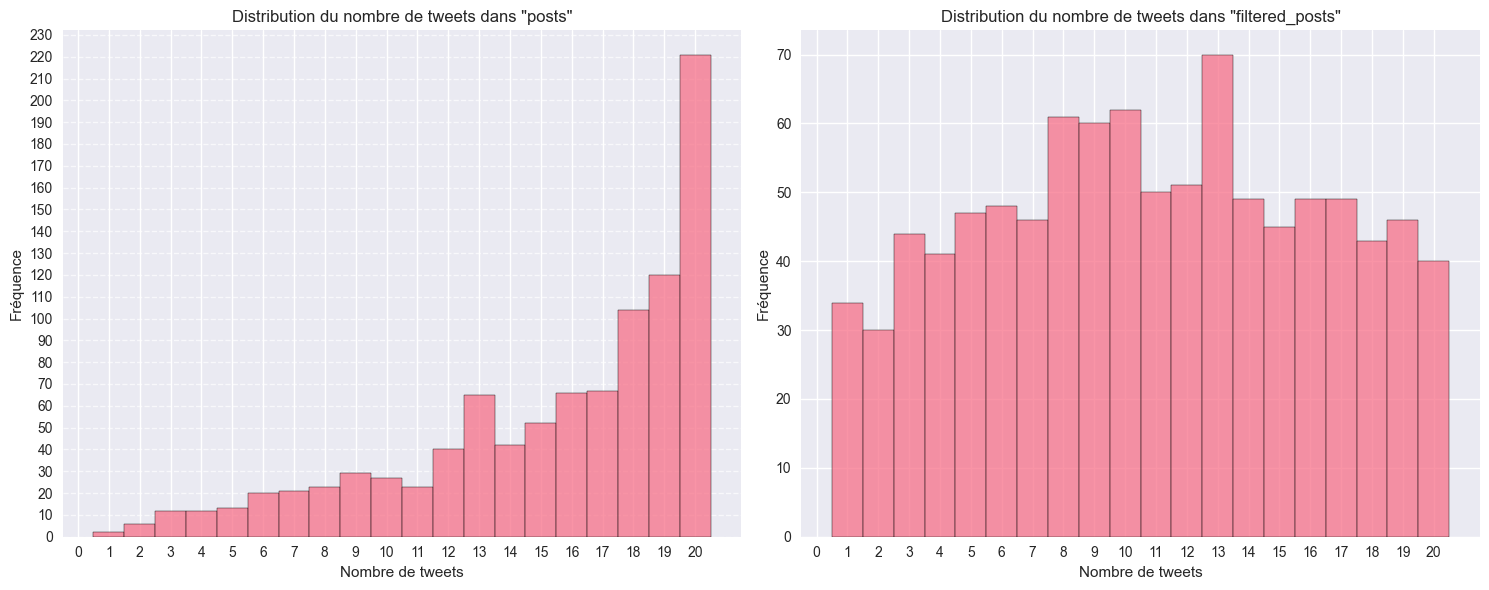

In [320]:
# Configuration des graphiques
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")

# Déterminer la plage des données pour définir les bins
max_count = max(df_filtered['tweet_counts_original'].max(), df_filtered['tweet_counts_filtered'].max())
bins = np.arange(-0.5, max_count + 1.5, 1)  # Bins centrés sur les entiers

# Créer une figure avec deux sous-graphiques
fig, axes = plt.subplots(1, 2, figsize=(15, 6))

# Histogramme pour les posts initiaux
sns.histplot(df_filtered['tweet_counts_original'], bins=bins, kde=False, ax=axes[0], discrete=True)
axes[0].set_title('Distribution du nombre de tweets dans "posts"')
axes[0].set_xlabel('Nombre de tweets')
axes[0].set_ylabel('Fréquence')
axes[0].set_xticks(np.arange(0, max_count + 1, 1))  # Ticks entiers

# Amélioration de la précision de l'axe vertical
y_max = axes[0].get_ylim()[1]
axes[0].set_yticks(np.arange(0, int(y_max) + 1, 10))  # Ticks entiers pour chaque valeur de fréquence
axes[0].grid(axis='y', linestyle='--', alpha=0.7)  # Ajouter une grille horizontale

# Histogramme pour les posts filtrés
sns.histplot(df_filtered['tweet_counts_filtered'], bins=bins, kde=False, ax=axes[1], discrete=True)
axes[1].set_title('Distribution du nombre de tweets dans "filtered_posts"')
axes[1].set_xlabel('Nombre de tweets')
axes[1].set_ylabel('Fréquence')
axes[1].set_xticks(np.arange(0, max_count + 1, 1))  # Ticks entiers

# Si le max_count est grand, limitons les ticks pour éviter l'encombrement
if max_count > 20:
    for ax in axes:
        ax.set_xticks(np.arange(0, max_count + 1, 2))  # Ticks tous les 2 entiers

plt.tight_layout()
plt.show()

## Normalisation des données

In [327]:
def calculate_view_normalized_metric(posts, metric_name):
    """
    Calculates the rate of a metric relative to the total number of views.
    """
    if not posts:
        return 0
    
    total_metric = sum(post.get(metric_name, 0) for post in posts.values())
    total_views = sum(post.get('views_count', 0) for post in posts.values())
    
    if total_views == 0:
        return 0
    
    return total_metric / total_views
    
# Create the new view-normalized feature columns
df_filtered['likes_per_views'] = df_filtered['filtered_posts'].apply(lambda x: calculate_view_normalized_metric(x, 'likes_count'))
df_filtered['retweets_per_views'] = df_filtered['filtered_posts'].apply(lambda x: calculate_view_normalized_metric(x, 'retweet_count'))
df_filtered['replies_per_views'] = df_filtered['filtered_posts'].apply(lambda x: calculate_view_normalized_metric(x, 'reply_count'))
df_filtered.head()

,id,name,screen_name,description,is_blue_verified,followers_count,following_count,posts_count,posts,created_at,market_cap_rank,sync_at,filtered_posts,tweet_counts_original,tweet_counts_filtered,likes_per_views,retweets_per_views,replies_per_views
0,357312062,Bitcoin,Bitcoin,Bitcoin is an open source censorship-resistant...,1,7788378,13,28585,"{""tweet-1941894468061569375"": {""created_at"": ""...",1313643968,1,1751827830,{'tweet-1941878501667110957': {'created_at': '...,20,18,0.011792,0.003456,0.001853
1,2312333412,Ethereum,ethereum,"The universal platform for crypto, blockchain ...",1,3847295,0,4299,"{""tweet-1937947714920300627"": {""created_at"": ""...",1390763724,2,0,{'tweet-1935010523776430587': {'created_at': '...,20,4,0.009494,0.001682,0.001073
2,2893133450,Tether,Tether_to,Finance | Power | Data | Edu | Evo - Empowerin...,1,537857,246,1755,"{""tweet-1938132804270739805"": {""created_at"": ""...",1415394150,3,0,{'tweet-1936333412077322739': {'created_at': '...,20,5,0.003922,0.000672,0.000759
3,1051053836,Ripple,Ripple,We're building the Internet of Value.,1,3146294,986,9103,"{""tweet-1938276067502133466"": {""created_at"": ""...",1356983139,4,0,{'tweet-1938221710391587076': {'created_at': '...,20,6,0.013310,0.003412,0.000577
4,1052454006537314306,BNB Chain,BNBCHAIN,$100M Incentive Program is introducing a new d...,1,3848162,627,26821,"{""tweet-1938269416271061330"": {""created_at"": ""...",1539759563,5,0,{'tweet-1938269324575187353': {'created_at': '...,13,9,0.005952,0.001455,0.004204


In [322]:
# Suppression des valeurs abérantes
def remove_outliers(df_iqr, columns, lower_quantile=0.25, upper_quantile=0.75):
    # Calculer les quantiles sur les colonnes spécifiées
    Q1 = df_iqr[columns].quantile(lower_quantile)
    Q3 = df_iqr[columns].quantile(upper_quantile)
    IQR = Q3 - Q1
    
    # Créer le masque d'outliers en s'assurant de l'alignement
    subset_df = df_iqr[columns]  # Extraire uniquement les colonnes d'intérêt
    
    # Conditions d'outliers alignées
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    
    # Identifier les outliers (vectorisé et aligné)
    is_outlier = ((subset_df < lower_bound) | (subset_df > upper_bound)).any(axis=1)
    
    # Supprimer les outliers du DataFrame complet
    df_clean_iqr = df_iqr[~is_outlier].reset_index(drop=True)
    
    print(f"Nombre d'outliers détectés (IQR): {is_outlier.sum()}")
    print(f"Dataset nettoyé: {len(df_clean_iqr)} lignes sur {len(df_iqr)} originales")
    
    return df_clean_iqr

# Remove outliers from engagement_rate
df_clean_iqr = remove_outliers(df_filtered, [
    'likes_per_views',
    'retweets_per_views',
    'replies_per_views'])

# plt.figure(figsize=(10, 6))
# sns.boxplot(y=df_clean_iqr['likes_per_views'])
# plt.title('Distribution des likes par vues')
# plt.ylabel('Likes per views')
# plt.grid(axis='y', linestyle='--', alpha=0.7)
# plt.tight_layout()
# plt.show()


Nombre d'outliers détectés (IQR): 138
Dataset nettoyé: 827 lignes sur 965 originales


# Sélection de l'algorithme et du modèle


📈 Features d'engagement créées:
       likes_per_views  retweets_per_views  replies_per_views
count       827.000000          827.000000         827.000000
mean          0.013839            0.002997           0.002222
std           0.008750            0.002517           0.001622
min           0.000160            0.000000           0.000000
25%           0.007456            0.001189           0.001024
50%           0.012129            0.002202           0.001789
75%           0.018650            0.004002           0.003029
max           0.043334            0.011751           0.007634


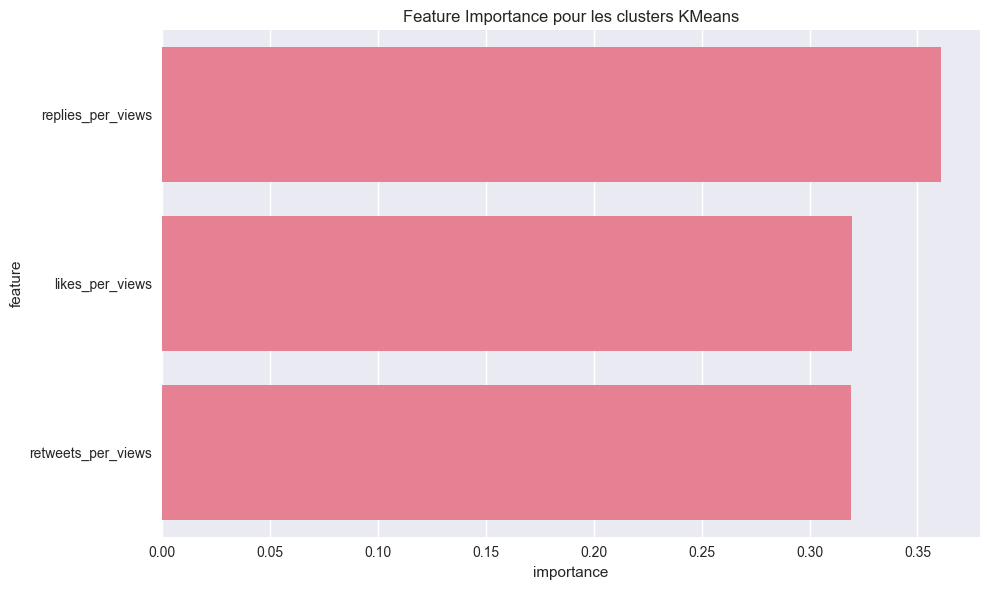

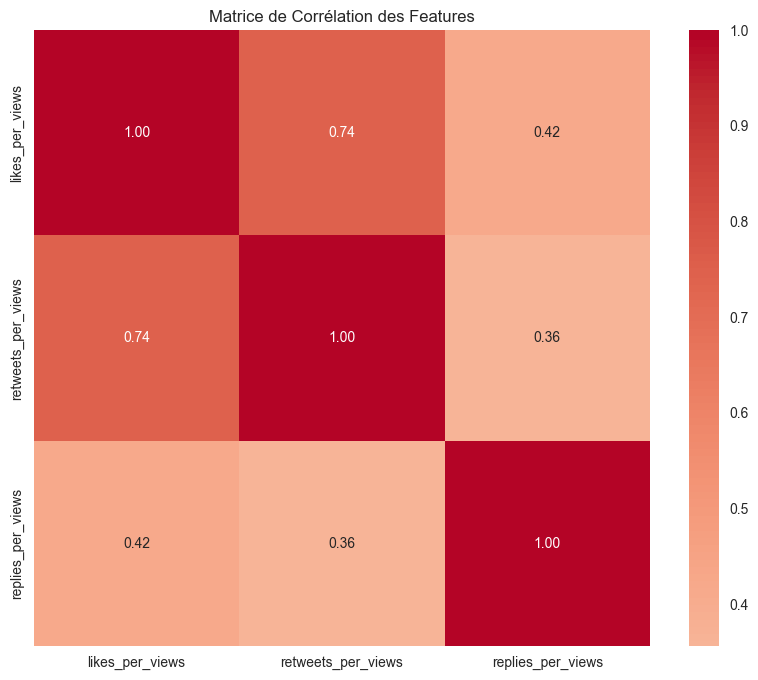

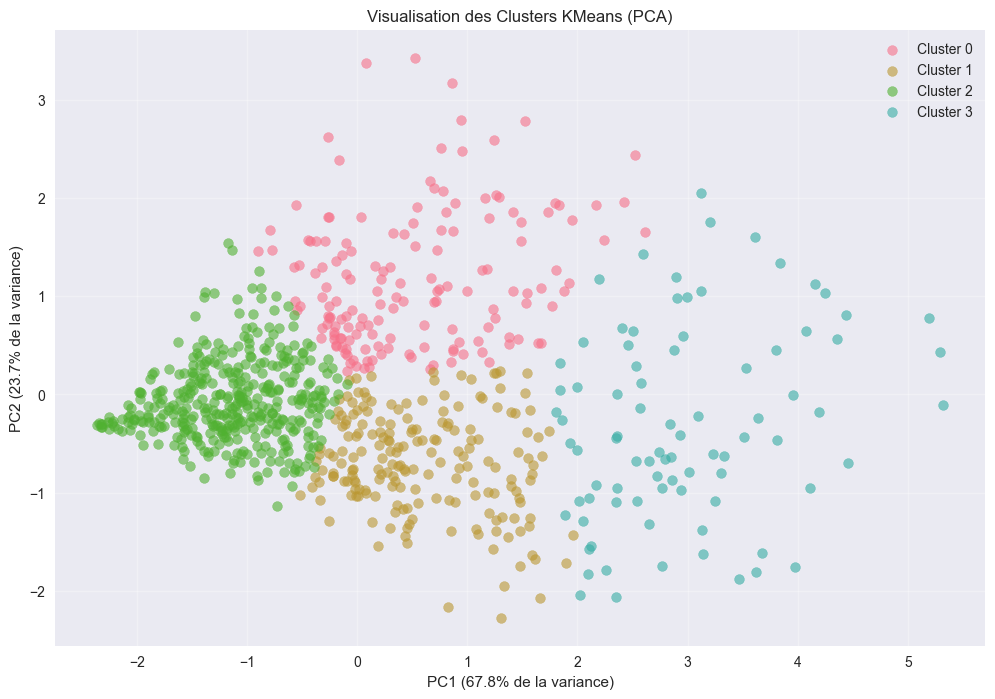

2025-07-07 19:12:20,759 - matplotlib.category - INFO - Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
2025-07-07 19:12:20,762 - matplotlib.category - INFO - Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.


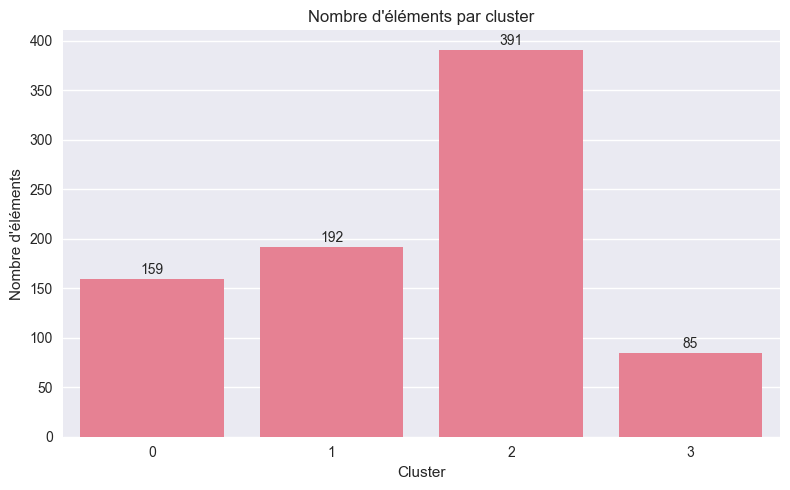

In [323]:
df_features = df_clean_iqr.copy()
features = [
    # 'followers_count',
    #'following_count',
    # 'posts_count',
    # 'market_cap_rank',    
    # 'tweet_counts_filtered',
    # 'likes_per_follower',
    # 'retweets_per_follower',
    # 'replies_per_follower',
    # 'views_per_follower',
    'likes_per_views',
    'retweets_per_views',
    'replies_per_views'
]

print("\n📈 Features d'engagement créées:")
print(df_features[features].describe())

# Extraction des caractéristiques
X = df_features[features]

# Normalisation des données
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Effectuer le clustering KMeans
n_clusters = 4
kmeans_model = KMeans(n_clusters=n_clusters, random_state=42, n_init=10)
cluster_labels = kmeans_model.fit_predict(X_scaled)

# Ajouter les clusters au DataFrame original
df_features["cluster"] = cluster_labels

# Calculer l'importance des features via RandomForest sur les clusters
rf_model = RandomForestClassifier(random_state=42)
rf_model.fit(X_scaled, cluster_labels)
importances_f = rf_model.feature_importances_

# Créer un DataFrame pour visualiser l'importance des features
feature_importance_df = pd.DataFrame({
    "feature": features,
    "importance": importances_f
}).sort_values(by="importance", ascending=False)

# Visualiser l'importance des features
plt.figure(figsize=(10, 6))
sns.barplot(x="importance", y="feature", data=feature_importance_df)
plt.title("Feature Importance pour les clusters KMeans")
plt.tight_layout()
plt.show()

# Matrice de corrélation
plt.figure(figsize=(10, 8))
correlation_matrix = df_features[features].corr()
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', center=0,
            square=True, fmt='.2f')
plt.title('Matrice de Corrélation des Features')
plt.show()

# Visualiser les clusters avec PCA
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)

plt.figure(figsize=(12, 8))
for i in range(n_clusters):
    mask = df_features['cluster'] == i
    plt.scatter(X_pca[mask, 0], X_pca[mask, 1], 
               label=f'Cluster {i}', alpha=0.6, s=50)

plt.xlabel(f'PC1 ({pca.explained_variance_ratio_[0]:.1%} de la variance)')
plt.ylabel(f'PC2 ({pca.explained_variance_ratio_[1]:.1%} de la variance)')
plt.title('Visualisation des Clusters KMeans (PCA)')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

# Afficher le nombre d'éléments dans chaque cluster
cluster_counts = df_features['cluster'].value_counts().sort_index()
plt.figure(figsize=(8, 5))
sns.barplot(x=cluster_counts.index, y=cluster_counts.values)
plt.title('Nombre d\'éléments par cluster')
plt.xlabel('Cluster')
plt.ylabel('Nombre d\'éléments')
plt.xticks(range(n_clusters))
for i, count in enumerate(cluster_counts.values):
    plt.text(i, count + 5, str(count), ha='center')
plt.tight_layout()
plt.show()

# Evaluation du modèle

In [324]:
# Analyse des clusters
print(f"\n🎯 Résultats du clustering (k={n_clusters}):")
print(f"Silhouette Score: {silhouette_score(X_scaled, cluster_labels):.3f}")

cluster_means = df_features.groupby('cluster')[features].mean()
print("\n📋 Profil moyen des clusters:")
cluster_means


🎯 Résultats du clustering (k=4):
Silhouette Score: 0.382

📋 Profil moyen des clusters:


,likes_per_views,retweets_per_views,replies_per_views
cluster,,,
0,0.014294,0.002493,0.004240
1,0.019342,0.004408,0.001668
2,0.007548,0.001354,0.001269
3,0.029496,0.008310,0.004079


In [328]:
cluster_dfs = {}
for k in range(n_clusters):
    cluster_dfs[f'Cluster {k}'] = df_features[df_features['cluster'] == k]['screen_name'].reset_index(drop=True)
display(pd.concat(cluster_dfs, axis=1).head(10))

display(df_features[df_features['name'] == 'Bitcoin'][
    ['screen_name', 'likes_per_views', 'retweets_per_views', 'replies_per_views', 'cluster']
])


,Cluster 0,Cluster 1,Cluster 2,Cluster 3
0,BNBCHAIN,Bitcoin,ethereum,eth_classic
1,trondao,Ripple,Tether_to,RealFlokiInu
2,SuiNetwork,chainlink,solana,OnyxDAO
3,bitgetglobal,StellarOrg,circle,BuildOnBeam
4,Uniswap,avax,dogecoin,BabyDogeCoin
5,Aptos,hedera,Cardano,Toshi_base
6,okx,PiCoreTeam,HyperliquidX,Sia__Foundation
7,NEARProtocol,pepecoineth,bitfinex,fasttoken_com
8,cronos_chain,dfinity,Shibtoken,BeldexCoin
9,kucoincom,0xMantle,litecoin,LegacyNetworkio


,screen_name,likes_per_views,retweets_per_views,replies_per_views,cluster
0,Bitcoin,0.011792,0.003456,0.001853,1


## Labelisation

- `Cluster 0` - `Engagement Équilibré`

    Profils avec un engagement modéré et bien réparti entre likes, retweets et replies.
    
    Représentent probablement des comptes crypto généralistes avec une audience stable.
    

- `Cluster 1` - `Forte Attraction`

    Comptes générant beaucoup de likes mais peu de replies, suggérant un contenu populaire mais moins propice au débat.
    
    Probablement des comptes de news crypto ou d'influenceurs.


- `Cluster 2` - `Faible Engagement`

    Profils avec les ratios d'engagement les plus bas sur tous les indicateurs.
    
    Possiblement des comptes dormants, bots, ou comptes avec un contenu peu engageant.


- `Cluster 3` - `Haute Viralité`

    Comptes avec les ratios d'engagement les plus élevés, particulièrement en retweets.
    
    Probablement des comptes d'actualités crypto, d'analyses ou de contenus très partagés par la communauté.

In [329]:
def assign_engagement_labels(df_clustered):
    """
    Ajoute une colonne 'engagement_level' au DataFrame avec les labels correspondants aux clusters:
    - Cluster 0 → "Engagement Équilibré"
    - Cluster 1 → "Forte Attraction" 
    - Cluster 2 → "Faible Engagement"
    - Cluster 3 → "Haute Viralité"
    """
    # Mapping des clusters vers les labels
    engagement_labels = {
        0: "Engagement Équilibré",
        1: "Forte Attraction",
        2: "Faible Engagement",
        3: "Haute Viralité"
    }
    
    # Créer une copie du DataFrame pour éviter de modifier l'original
    result_df = df_clustered.copy()
    
    # Ajouter la colonne engagement_level
    result_df['engagement_level'] = result_df['cluster'].map(engagement_labels)
    
    return result_df

df_features = assign_engagement_labels(df_features)

df_features.head()

,id,name,screen_name,description,is_blue_verified,followers_count,following_count,posts_count,posts,created_at,market_cap_rank,sync_at,filtered_posts,tweet_counts_original,tweet_counts_filtered,likes_per_views,retweets_per_views,replies_per_views,cluster,engagement_level
0,357312062,Bitcoin,Bitcoin,Bitcoin is an open source censorship-resistant...,1,7788378,13,28585,"{""tweet-1941894468061569375"": {""created_at"": ""...",1313643968,1,1751827830,{'tweet-1941878501667110957': {'created_at': '...,20,18,0.011792,0.003456,0.001853,1,Forte Attraction
1,2312333412,Ethereum,ethereum,"The universal platform for crypto, blockchain ...",1,3847295,0,4299,"{""tweet-1937947714920300627"": {""created_at"": ""...",1390763724,2,0,{'tweet-1935010523776430587': {'created_at': '...,20,4,0.009494,0.001682,0.001073,2,Faible Engagement
2,2893133450,Tether,Tether_to,Finance | Power | Data | Edu | Evo - Empowerin...,1,537857,246,1755,"{""tweet-1938132804270739805"": {""created_at"": ""...",1415394150,3,0,{'tweet-1936333412077322739': {'created_at': '...,20,5,0.003922,0.000672,0.000759,2,Faible Engagement
3,1051053836,Ripple,Ripple,We're building the Internet of Value.,1,3146294,986,9103,"{""tweet-1938276067502133466"": {""created_at"": ""...",1356983139,4,0,{'tweet-1938221710391587076': {'created_at': '...,20,6,0.013310,0.003412,0.000577,1,Forte Attraction
4,1052454006537314306,BNB Chain,BNBCHAIN,$100M Incentive Program is introducing a new d...,1,3848162,627,26821,"{""tweet-1938269416271061330"": {""created_at"": ""...",1539759563,5,0,{'tweet-1938269324575187353': {'created_at': '...,13,9,0.005952,0.001455,0.004204,0,Engagement Équilibré


In [331]:
# ANALYSE DES COMPTES REPRÉSENTATIFS
 
print("\n🔍 ANALYSE DES COMPTES REPRÉSENTATIFS:")

for engagement_level in [
    "Engagement Équilibré",
    "Forte Attraction",
    "Faible Engagement",
    "Haute Viralité"
    ]:
    print(f"\n--- {engagement_level.upper()} ---")
    subset = df_features[df_features['engagement_level'] == engagement_level]
    
    # Statistiques du groupe
    print(f"Nombre de comptes: {len(subset)}")
    print(f"Followers moyen: {subset['followers_count'].mean():.0f}")
    
    # Top 3 comptes du groupe
    top_accounts = subset.nlargest(3, 'cluster')[
        ['screen_name', 'followers_count', 'retweets_per_views', 'replies_per_views', 'likes_per_views']
    ]
    print("Top 3 comptes:")
    print(top_accounts.to_string(index=False))


🔍 ANALYSE DES COMPTES REPRÉSENTATIFS:

--- ENGAGEMENT ÉQUILIBRÉ ---
Nombre de comptes: 159
Followers moyen: 387126
Top 3 comptes:
screen_name  followers_count  retweets_per_views  replies_per_views  likes_per_views
   BNBCHAIN          3848162            0.001455           0.004204         0.005952
    trondao          1724484            0.002207           0.004200         0.011878
 SuiNetwork          1103021            0.001474           0.004024         0.009186

--- FORTE ATTRACTION ---
Nombre de comptes: 192
Followers moyen: 288055
Top 3 comptes:
screen_name  followers_count  retweets_per_views  replies_per_views  likes_per_views
    Bitcoin          7788378            0.003456           0.001853         0.011792
     Ripple          3146294            0.003412           0.000577         0.013310
  chainlink          1328955            0.003229           0.001166         0.020288

--- FAIBLE ENGAGEMENT ---
Nombre de comptes: 391
Followers moyen: 654734
Top 3 comptes:
screen_name 

## Déterminer le nombre optimal de clusters avec la méthode du coude

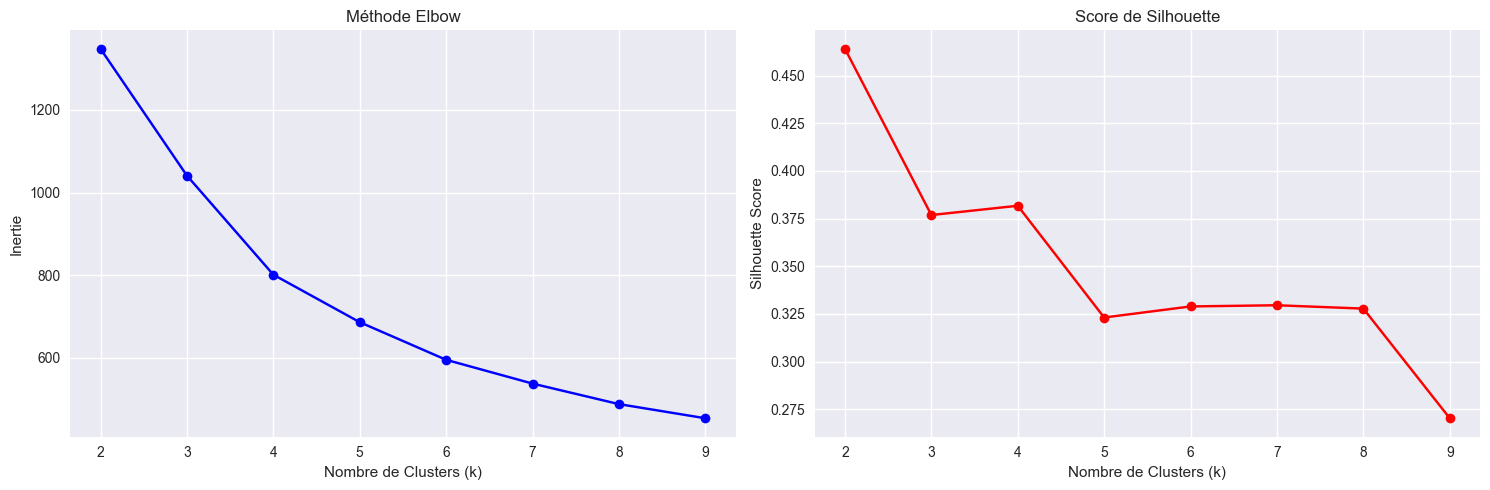

📊 Scores de Silhouette par nombre de clusters:
k=2: 0.464
k=3: 0.377
k=4: 0.382
k=5: 0.323
k=6: 0.329
k=7: 0.330
k=8: 0.328
k=9: 0.270


In [332]:
# Méthode Elbow
inertias = []
silhouette_scores = []
K_range = range(2, 10)

for k in K_range:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    kmeans.fit(X_scaled)
    inertias.append(kmeans.inertia_)
    silhouette_scores.append(silhouette_score(X_scaled, kmeans.labels_))

# Visualisation
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

# Elbow Method
ax1.plot(K_range, inertias, 'bo-')
ax1.set_xlabel('Nombre de Clusters (k)')
ax1.set_ylabel('Inertie')
ax1.set_title('Méthode Elbow')
ax1.grid(True)

# Silhouette Score
ax2.plot(K_range, silhouette_scores, 'ro-')
ax2.set_xlabel('Nombre de Clusters (k)')
ax2.set_ylabel('Silhouette Score')
ax2.set_title('Score de Silhouette')
ax2.grid(True)

plt.tight_layout()
plt.show()

print("📊 Scores de Silhouette par nombre de clusters:")
for k, score in zip(K_range, silhouette_scores):
    print(f"k={k}: {score:.3f}")

# Déploiement du modèle

In [ ]:
print(f"Using TensorFlow version {tf.__version__}")

print("Saving model with TensorFlow SavedModel format...")
model_dir = save_notebook_model(globals())
print(f"Model successfully saved to {model_dir}")

# Test loading the model

In [334]:
from utils.model_saver import load_model, predict_engagement

print("\nTesting model loading and prediction...")
loaded_model, metadata = load_model('engagement_clustering')
print(f"Model loaded successfully with metadata: {metadata}")

# Example prediction (adjust these values based on your actual features)
example_metrics = {
    'followers_count': 1000,
    'friends_count': 500,
    'listed_count': 50,
    'favourites_count': 2000,
    'statuses_count': 1500
}

engagement_level, cluster = predict_engagement(example_metrics, loaded_model, metadata)
print(f"Predicted engagement level: {engagement_level} (Cluster {cluster})")

2025-07-07 19:17:37,223 - utils.model_saver - INFO - Models directory: /Users/cedric/Projects/Alyra/xenty/models
2025-07-07 19:17:37,248 - utils.model_saver - INFO - TensorFlow model loaded from /Users/cedric/Projects/Alyra/xenty/models/engagement_clustering/tf_model
2025-07-07 19:17:37,249 - utils.model_saver - INFO - Engagement labels loaded from /Users/cedric/Projects/Alyra/xenty/models/engagement_clustering/engagement_labels.json
2025-07-07 19:17:37,250 - utils.model_saver - INFO - Feature names loaded from /Users/cedric/Projects/Alyra/xenty/models/engagement_clustering/features.json
2025-07-07 19:17:37,251 - utils.model_saver - INFO - Metadata loaded from /Users/cedric/Projects/Alyra/xenty/models/engagement_clustering/metadata.json



Testing model loading and prediction...


ValueError: too many values to unpack (expected 2)